# Pengembangan Model Klasifikasi Emosi (FER2013 + OpenFace)
Notebook ini menyiapkan pipeline end-to-end: OpenCV untuk preprocessing, MTCNN untuk deteksi wajah, OpenFace sebagai feature extractor (embedding), dan classifier emosi berbasis Dense di TensorFlow/Keras.

In [44]:
# Instalasi paket inti (jalankan sekali). OpenFace membutuhkan model nn4.small2.v1.t7 yang harus diunduh manual.
# Pastikan notebook dijalankan di environment dengan GPU bila tersedia untuk mempercepat training.
# Jika paket sudah terpasang, sel ini bisa dilewati.
%pip install --quiet opencv-python mtcnn tensorflow tensorflowjs scikit-learn matplotlib pandas tqdm openface

Note: you may need to restart the kernel to use updated packages.


In [45]:
import os
import cv2
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from mtcnn import MTCNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Kompatibilitas NumPy >=1.24 yang menghapus np.object
if not hasattr(np, 'object'):
    np.object = object

try:
    import tensorflowjs as tfjs  # opsional untuk ekspor tf.js
except Exception as e:
    tfjs = None
    print('tensorflowjs gagal diimpor, ekspor tf.js akan dilewati:', e)

from deepface import DeepFace  # gunakan OpenFace via DeepFace

# Pastikan OpenCV dan MTCNN digunakan hanya untuk preprocessing dan deteksi wajah, bukan klasifikasi.
print('TensorFlow version:', tf.__version__)

tensorflowjs gagal diimpor, ekspor tf.js akan dilewati: module 'tensorflow.compat.v1' has no attribute 'estimator'
TensorFlow version: 2.20.0


In [ ]:
# Konfigurasi path dataset FER2013 dan model OpenFace.
# Pastikan struktur folder: train/<class>/*.png, test/<class>/*.png sesuai dataset FER2013 yang diekstrak.
DATA_ROOT = 'archive'  
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
TEST_DIR = os.path.join(DATA_ROOT, 'test')


OPENFACE_MODEL_PATH = 'models/nn4.small2.v1.t7' 
OPENFACE_INPUT_SIZE = 96 

In [47]:
# Inisialisasi detektor wajah MTCNN dan feature extractor OpenFace via DeepFace.
# OpenCV hanya untuk loading + resize + normalisasi; MTCNN khusus untuk deteksi; OpenFace hanya untuk ekstraksi embedding (bukan classifier).
detector = MTCNN()
openface_model = DeepFace.build_model('OpenFace')  # kompatibel Python 3 via DeepFace

class_labels = sorted(os.listdir(TRAIN_DIR))
label_to_idx = {lbl: i for i, lbl in enumerate(class_labels)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

def load_image(path):
    img = cv2.imread(path)  # OpenCV load BGR
    if img is None:
        return None
    # FER2013 banyak grayscale; konversi ke RGB untuk konsistensi downstream.
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def detect_and_crop(img):
    # Deteksi wajah dengan MTCNN, ambil bounding box terbesar.
    faces = detector.detect_faces(img)
    if not faces:
        return None
    faces = sorted(faces, key=lambda f: f['box'][2] * f['box'][3], reverse=True)
    x, y, w, h = faces[0]['box']
    x, y = max(0, x), max(0, y)
    return img[y:y+h, x:x+w]

def preprocess_for_openface(img):
    # Resize ke dimensi OpenFace dan normalisasi 0-1 untuk kestabilan embedding.
    img_resized = cv2.resize(img, (OPENFACE_INPUT_SIZE, OPENFACE_INPUT_SIZE))
    img_norm = img_resized / 255.0
    return img_norm

def image_to_embedding(img):
    # DeepFace OpenFace: gunakan represent dengan detector_backend='skip' karena deteksi wajah sudah MTCNN.
    # API terbaru tidak menerima argumen 'model'; hanya berikan model_name dan enforce_detection=False.
    # Input harus array RGB/BGR 0-255; kita konversi ke BGR uint8 sesuai ekspektasi backend.
    img_bgr = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    reps = DeepFace.represent(
        img_path=img_bgr,
        model_name='OpenFace',
        enforce_detection=False,
        detector_backend='skip'
    )
    emb = reps[0]['embedding'] if isinstance(reps, list) else reps['embedding']
    return np.array(emb, dtype='float32')

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\hanif\anaconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\hanif\anaconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\hanif\anaconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


In [48]:
def build_embeddings(split_dir):
    embeddings, labels = [], []
    for lbl in class_labels:
        img_paths = glob.glob(os.path.join(split_dir, lbl, '*'))
        for path in tqdm(img_paths, desc=f'Embed {lbl}', leave=False):
            img = load_image(path)
            if img is None:
                continue
            face = detect_and_crop(img)
            if face is None:
                continue
            img_pp = preprocess_for_openface(face)
            emb = image_to_embedding(img_pp)
            embeddings.append(emb)
            labels.append(label_to_idx[lbl])
    return np.vstack(embeddings), np.array(labels)

X_train_emb, y_train = build_embeddings(TRAIN_DIR)
X_test_emb, y_test = build_embeddings(TEST_DIR)
print('Train embeddings:', X_train_emb.shape, 'Test embeddings:', X_test_emb.shape)

Train embeddings: (23951, 128) Test embeddings: (5986, 128)


In [49]:
# Split train menjadi train/val dengan stratifikasi agar proporsi label seimbang.
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_emb, y_train, test_size=0.2, random_state=42, stratify=y_train
 )
num_classes = len(class_labels)
input_dim = X_train.shape[1]
print('Input embedding dim:', input_dim)

Input embedding dim: 128


In [50]:
def build_classifier(input_dim, num_classes, dropout=0.3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_classifier(input_dim, num_classes)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,823 (261.03 KB)

 Trainable params: 66,823 (261.03 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Training classifier dengan early stopping untuk mencegah overfitting.
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
history = model.fit(
    X_train, y_train_split,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3099 - loss: 1.7193 - val_accuracy: 0.3561 - val_loss: 1.6376
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3581 - loss: 1.6352 - val_accuracy: 0.3728 - val_loss: 1.6027
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3681 - loss: 1.6115 - val_accuracy: 0.3788 - val_loss: 1.5857
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3761 - loss: 1.5945 - val_accuracy: 0.3886 - val_loss: 1.5781
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3870 - loss: 1.5772 - val_accuracy: 0.3960 - val_loss: 1.5660
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3913 - loss: 1.5673 - val_accuracy: 0.3934 - val_loss: 1.5614
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3945 - loss: 1.5592 - val_accuracy: 0.4024 - val_loss: 1.5516
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3973 - loss: 1.5476 - val_accu

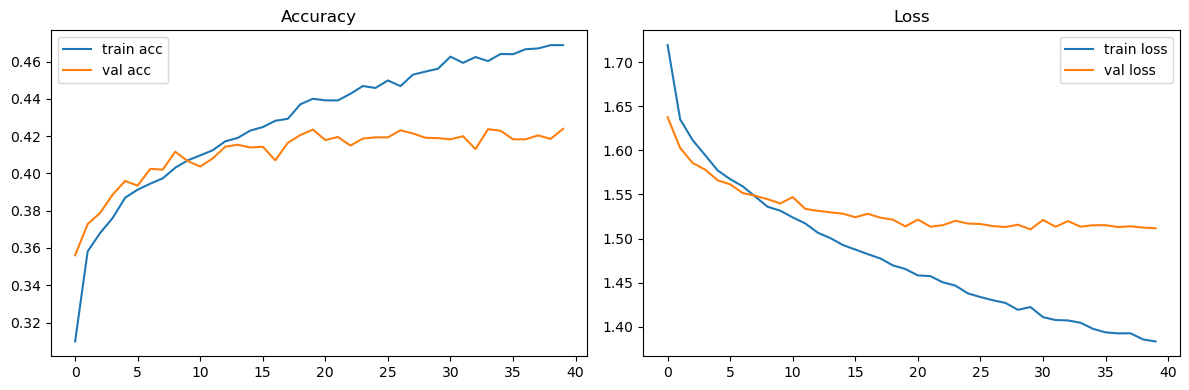

In [52]:
# Plot akurasi dan loss untuk laporan.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='train acc')
axes[0].plot(history.history['val_accuracy'], label='val acc')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[1].plot(history.history['loss'], label='train loss')
axes[1].plot(history.history['val_loss'], label='val loss')
axes[1].set_title('Loss')
axes[1].legend()
plt.tight_layout()
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test accuracy: 0.4227
              precision    recall  f1-score   support

       angry       0.37      0.29      0.32       788
     disgust       0.32      0.08      0.13        84
        fear       0.28      0.11      0.15       820
       happy       0.52      0.71      0.60      1528
     neutral       0.36      0.45      0.40      1087
         sad       0.33      0.31      0.32       966
    surprise       0.50      0.47      0.48       713

    accuracy                           0.42      5986
   macro avg       0.38      0.35      0.34      5986
weighted avg       0.40      0.42      0.40      5986



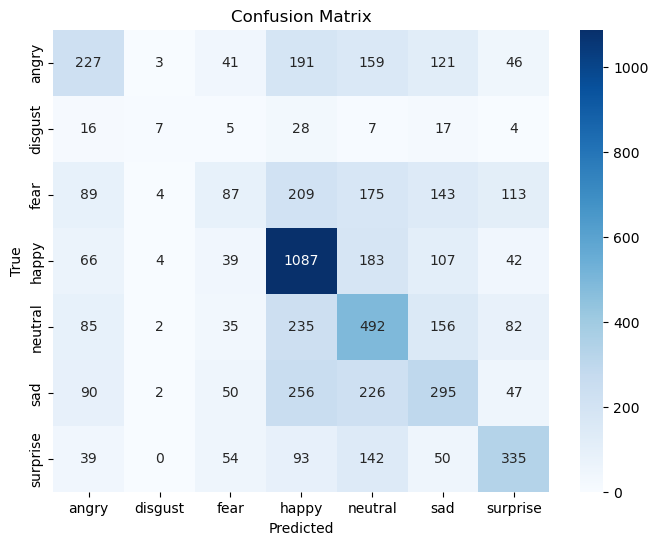

In [53]:
# Evaluasi pada set test: akurasi, laporan klasifikasi, dan confusion matrix.
test_probs = model.predict(X_test_emb)
test_pred = np.argmax(test_probs, axis=1)
test_acc = np.mean(test_pred == y_test)
print(f'Test accuracy: {test_acc:.4f}')
print(classification_report(y_test, test_pred, target_names=class_labels))

cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Simpan model: format H5 dan TensorFlow.js.
os.makedirs('saved_models', exist_ok=True)
h5_path = os.path.join('saved_models', 'emotion_classifier_openface.h5')
model.save(h5_path)
print('Saved H5 to', h5_path)

# Ekspor TF.js opsional; hanya dijalankan jika tensorflowjs berhasil diimpor.
if tfjs is not None:
    tfjs_path = os.path.join('saved_models', 'tfjs_model')
    tfjs.converters.save_keras_model(model, tfjs_path)
    print('Saved TF.js model to', tfjs_path)
else:
    print('Lewati ekspor TF.js karena tensorflowjs belum tersedia. Install/ulang import bila diperlukan.')

Saved H5 to saved_models\emotion_classifier_openface.h5
Lewati ekspor TF.js karena tensorflowjs belum tersedia. Install/ulang import bila diperlukan.
